In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, datasets

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import os
# for dirname, _, filenames in os.walk('/kaggle/input/custom-digital-malayalam/digital_malayalam'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         break
    # break

## Function Declarations

In [175]:
def show_batch(images):
    fig,ax = plt.subplots(figsize=(16,12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images.cpu(),nrow=16).permute(1,2,0))
    
def pil_loader_rgba(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')
    
def show(image):
    fig,ax = plt.subplots()
    if isinstance(image, np.ndarray):
        ax.imshow(image)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        return ax
    image = image.numpy().transpose(1,2,0)
    
    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

def predict(image, model):
    image.to(device)
    outputs = model(image)
    return torch.argmax(outputs, dim=1)

def negate(batch):
    return 1-batch

In [18]:
height,width = 30,30
channels = 1

# Load Dataset

In [134]:
class SingleChannel(object):
    def __call__(self,img):
        img_array = np.array(img)
        img_single_channel = img_array[:,:,0]
        negated = 255-img_single_channel
        return Image.fromarray(negated)

transformer = transforms.Compose([
    SingleChannel(),
    transforms.ToTensor(),
    transforms.Resize((height,width)),
])

real_dataset = datasets.ImageFolder('/kaggle/input/third-dataset/third_dataset', transform=transformer)

real_train_size = int(0.8 * len(real_dataset))
real_test_size = len(dataset) - real_train_size

real_train_dataset, real_test_dataset = torch.utils.data.random_split(real_dataset, [real_train_size, real_test_size])

real_trainloader = torch.utils.data.DataLoader(real_train_dataset, batch_size = 64, shuffle=True)
real_testloader = torch.utils.data.DataLoader(real_test_dataset, batch_size = 64, shuffle=True)

In [136]:
class ConvertTransparentToWhite(object):
    def __call__(self,img):
        img_array = np.array(img)
        img_array = img_array[:,:,2:]
        img_no_alpha = np.squeeze(img_array[:,:,:1])
        alpha_channel = img_array[:,:,1]
        mask = alpha_channel==0
        img_no_alpha[mask] = [255]
        return Image.fromarray(img_no_alpha)


transformer = transforms.Compose([
    ConvertTransparentToWhite(),
    transforms.Resize(height),
    transforms.ToTensor()
])


dataset = datasets.ImageFolder('/kaggle/input/custom-digital-malayalam/digital_malayalam/', transform=transformer,loader=pil_loader_rgba)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [137]:
char_to_label = {}
label_to_char = {}

for i, (k,v) in enumerate(dataset.class_to_idx.items()):
    char_to_label[k] = v
    label_to_char[v] = k
num_classes = len(char_to_label)
print("Number of classes: ", num_classes)

Number of classes:  125


In [135]:
real_char_to_label = {}
real_label_to_char = {}
for i, (k,v) in enumerate(real_dataset.class_to_idx.items()):
    real_char_to_label[k] = v
    real_label_to_char[v] = k
real_num_classes = len(real_char_to_label)
print("Number of classes: ", real_num_classes)

Number of classes:  34


# Visualize data

In [138]:
print(label_to_char)

{0: 'അ', 1: 'ആ', 2: 'ഇ', 3: 'ഉ', 4: 'ഋ', 5: 'എ', 6: 'ഏ', 7: 'ഒ', 8: 'ക', 9: 'ക്ക', 10: 'ക്ത', 11: 'ക്ല', 12: 'ക്ഷ', 13: 'ഖ', 14: 'ഗ', 15: 'ഗ്ഗ', 16: 'ഗ്ന', 17: 'ഗ്മ', 18: 'ഗ്ല', 19: 'ഘ', 20: 'ങ', 21: 'ങ്ക', 22: 'ങ്ങ', 23: 'ച', 24: 'ച്ച', 25: 'ച്ഛ', 26: 'ഛ', 27: 'ജ', 28: 'ജ്ജ', 29: 'ജ്ഞ', 30: 'ഝ', 31: 'ഞ', 32: 'ഞ്ച', 33: 'ഞ്ഞ', 34: 'ട', 35: 'ട്ട', 36: 'ഠ', 37: 'ഡ', 38: 'ഡ്ഡ', 39: 'ഢ', 40: 'ണ', 41: 'ണ്ട', 42: 'ണ്ഡ', 43: 'ണ്ണ', 44: 'ണ്മ', 45: 'ണ്\u200d', 46: 'ത', 47: 'ത്ത', 48: 'ത്ഥ', 49: 'ത്ഭ', 50: 'ത്മ', 51: 'ത്സ', 52: 'ഥ', 53: 'ദ', 54: 'ദ്ദ', 55: 'ദ്ധ', 56: 'ധ', 57: 'ന', 58: 'ന്ത', 59: 'ന്ഥ', 60: 'ന്ദ', 61: 'ന്ധ', 62: 'ന്ന', 63: 'ന്മ', 64: 'ന്\u200d', 65: 'ന്\u200dറ', 66: 'പ', 67: 'പ്പ', 68: 'പ്ല', 69: 'ഫ', 70: 'ഫ്ല', 71: 'ബ', 72: 'ബ്ദ', 73: 'ബ്ധ', 74: 'ബ്ബ', 75: 'ബ്ല', 76: 'ഭ', 77: 'മ', 78: 'മ്പ', 79: 'മ്മ', 80: 'മ്ല', 81: 'യ', 82: 'യ്യ', 83: 'ര', 84: 'ര്\u200d', 85: 'റ', 86: 'റ്റ', 87: 'ല', 88: 'ല്ല', 89: 'ല്\u200d', 90: 'ള', 91: 'ള്ള', 92: 'ള്\u200d', 93: 'ഴ', 94: 'വ', 95: 'വ്വ', 96

dataset sample image shape:  torch.Size([1, 30, 30])


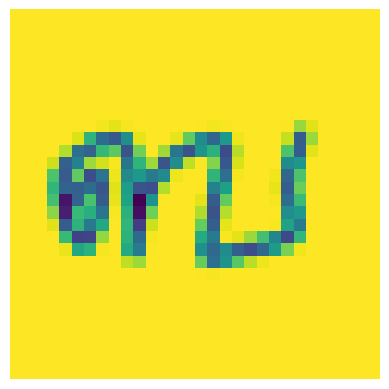

Label: 71
ബ


In [25]:
for images, labels in trainloader:
    # Select the first image from the batch
    img = images[1]
    print("dataset sample image shape: ", img.shape)
    label = labels[1].item()
    img = torch.transpose(img, 0, 2)
    img = torch.transpose(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # Print the corresponding label
    print("Label:", label)
    print(label_to_char[label])
    break

Batch shape:  torch.Size([64, 1, 30, 30])
ശ്ല യ്യ ഷ്ട മ ണ ന്‍റ ൃ ശ്ല ഞ്ഞ ല്‍ ല്‍ ന്ന ബ്ധ ബ്ധ ണ്ട ഒ ന്ത ഗ്ന ണ്ട ഉ മ്ല യ്യ വ്വ ഘ ഹ്ന ജ്ഞ ൗ ്യ ി ൃ ബ്ബ ന്ന ഫ മ്മ ഞ്ഞ ്ര ഞ്ഞ യ്യ ള ഭ ല്‍ ന്ദ ഡ ഫ ബ്ല ഥ ങ്ങ ബ്ബ െ ന്ഥ ബ്ബ ട േ ജ്ജ ദ ഷ്ട ബ്ല ഞ ന്‍ ്ര പ ട്ട ൂ ന്ഥ 

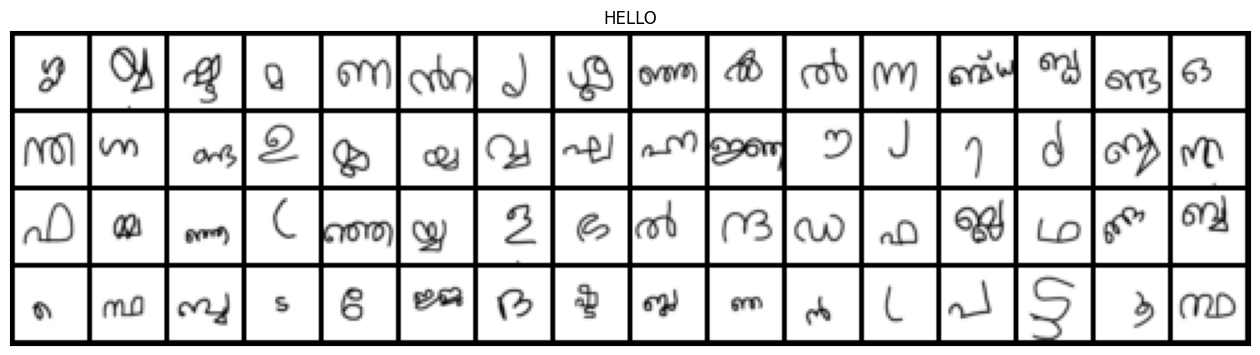

In [171]:
for images,labels in trainloader:
    show_batch(images)
    print("Batch shape: ",images.shape)
    for k in labels:
        print(label_to_char[k.item()], end=" ")
    break

Batch shape torch.Size([64, 1, 30, 30])
മ ര െ ഷ ത ച ച വ ര െ ഇ േ ജ ഋ ച ഒ ന ത സ ാ ദ ൗ റ െ ീ ാ ഉ ീ െ ഋ ആ ല ല ഒ ര ച േ സ ൗ ന ര േ സ ഇ ൗ ക ച െ ൗ ഞ ീ ദ ഞ േ ച ര വ വ ല ല്‍ േ ഋ ാ ന 

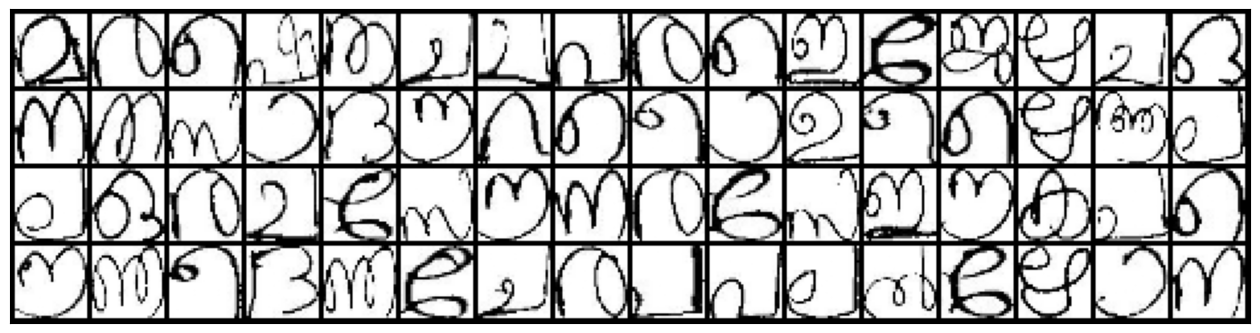

In [144]:
for images,labels in real_trainloader:
    show_batch(images)
    print("Batch shape",images.shape)
    for k in labels:
        print(real_label_to_char[k.item()], end=" ")
    break

In [145]:
dataiter = iter(trainloader)
images,labels = next(dataiter)
print("Batch type: ", type(images))
print("Shape of batch: ", images.shape)
print("Shape of labels: ", labels.shape)

Batch type:  <class 'torch.Tensor'>
Shape of batch:  torch.Size([64, 1, 30, 30])
Shape of labels:  torch.Size([64])


# Architecture

First Conv Layer: 
$$
n_{1} = height\\ 
f_{1} = 3\\
O_{1} = n_1-f_1+1\\
k_{1} = 16\\
$$
Maxpool layer:
$$
f_{2}\ (filter size) = 2\\
s_{2}\ (stride) = 2\\
O_{2} = \frac{O_{1}-f_{2}}{s_{2}} + 1\\
$$
Second Conv Layer:
$$
f_3 = 4\\
O_{3} = O_2 - f_3 + 1\\
k_3 = 32\\
$$
Maxpool layer:
$$
f_{4} = 2\\
s_{4} = 2\\
O_{4} = \frac{O_3 - f_4}{s_2} + 1
$$
Fully connected layer:
$$
n_5 = num\_classes
$$

In [146]:
class ConvNet(nn.Module):
    #initialize the class & the parameters
    def __init__(self):
        super(ConvNet, self).__init__()
        self.n1 = height
        
        self.f1 = 3 #Random
        self.k1 = 64
        self.O1 = self.n1 - self.f1 + 1
        
        self.f2 = 3
        self.s2 = 2
        self.O2 = np.floor((self.O1 - self.f2)/(self.s2)) + 1
        
        self.f3 = 3
        self.k3 = 32
        self.O3 = self.O2 - self.f3 + 1
        
        self.f4 = 3
        self.s4 = 2
        self.O4 = int(np.floor((self.O3 - self.f4)/(self.s4)) + 1)
        
        self.n5 = num_classes
        #conv layer 1 + max pool
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=self.k1, kernel_size=self.f1),
            nn.MaxPool2d(kernel_size=self.f2, stride=self.s2)
        )
        
        #conv layer 2 + max pool 
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=self.k1, out_channels=self.k3, kernel_size=self.f3),
            nn.MaxPool2d(kernel_size=self.f4, stride=self.s4)
        )
        
        #Avg pool
        self.avgpool = nn.AdaptiveAvgPool2d((3,3))
        #FC layer
        self.fc = nn.Linear(in_features=self.k3*9, out_features=num_classes)
        
    def forward(self, x, visualize=False):
        out = self.layer1(x)
        if visualize:
            print("Layer 1 output: ", out[:,0:3,:,:].shape)
            show_batch(out[:,0:3,:,:])
        out = self.layer2(out)
        if visualize:
            print("Layer 2 output:", out.shape)
            show_batch(out[:,0:3,:,:])
        out = self.avgpool(out)
        if visualize:
            print("Avg pool output: ", out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(3, 3))
  (fc): Linear(in_features=288, out_features=125, bias=True)
)


In [147]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
#5185701

55229


In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Cuda availability: ",torch.cuda.is_available())
print("Current device: ",device)

model.to(device)

Cuda availability:  True
Current device:  cuda


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(3, 3))
  (fc): Linear(in_features=288, out_features=125, bias=True)
)

# Model Training

In [32]:
'''
Load model
'''
model.load_state_dict(torch.load('/kaggle/input/mhcr-2/hcr(4).pt'))

<All keys matched successfully>

Input:  torch.Size([64, 1, 30, 30])
Layer 1 output:  torch.Size([64, 3, 13, 13])
Layer 2 output: torch.Size([64, 32, 5, 5])
Avg pool output:  torch.Size([64, 32, 3, 3])


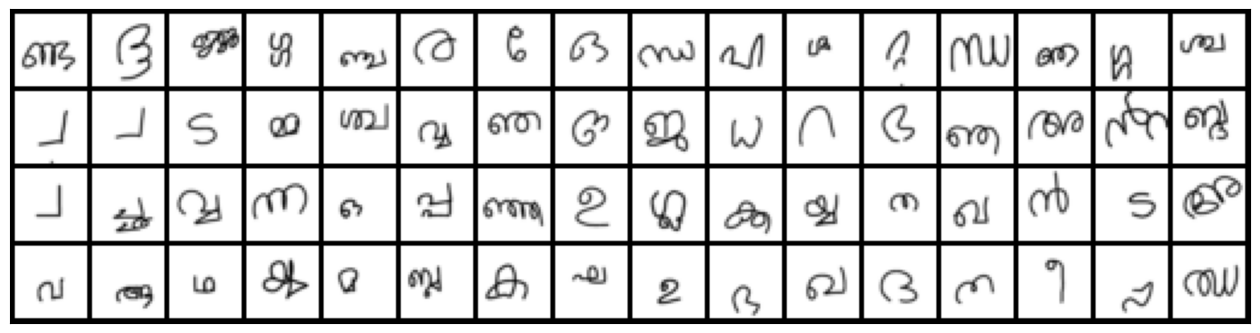

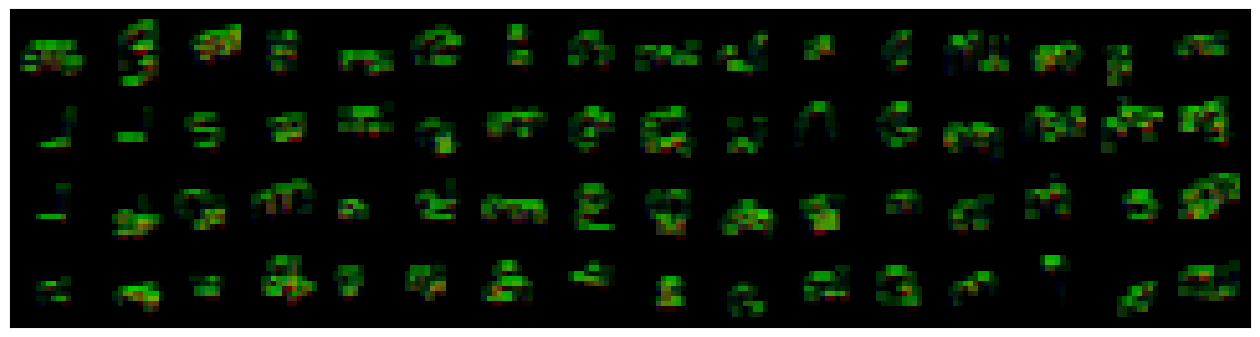

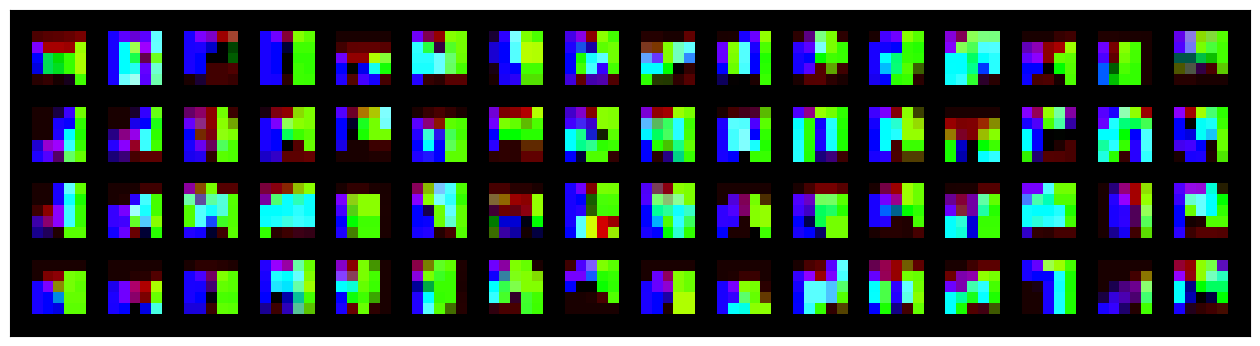

In [176]:
for images,labels in trainloader:
    show_batch(images)
    print("Input: ", images.shape)
    model(images.to(device),True)
    break

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Input:  torch.Size([64, 1, 30, 30])
Layer 1 output:  torch.Size([64, 3, 13, 13])
Layer 2 output: torch.Size([64, 32, 5, 5])
Avg pool output:  torch.Size([64, 32, 3, 3])


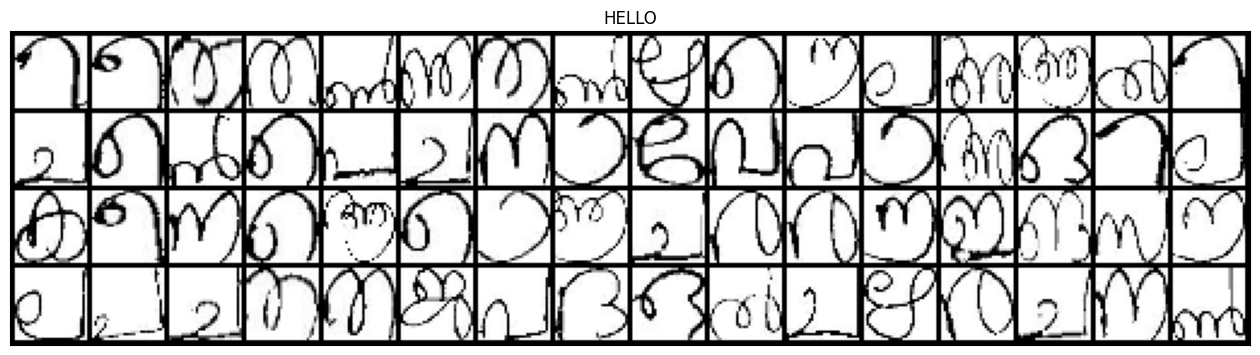

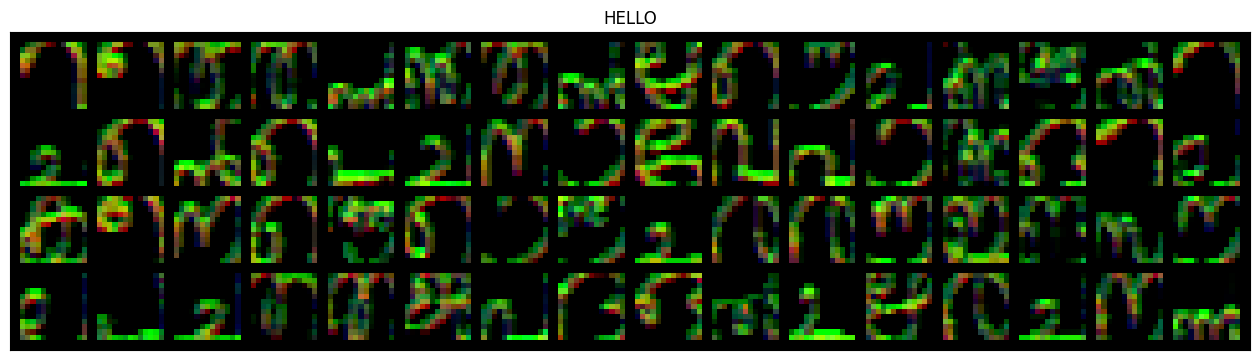

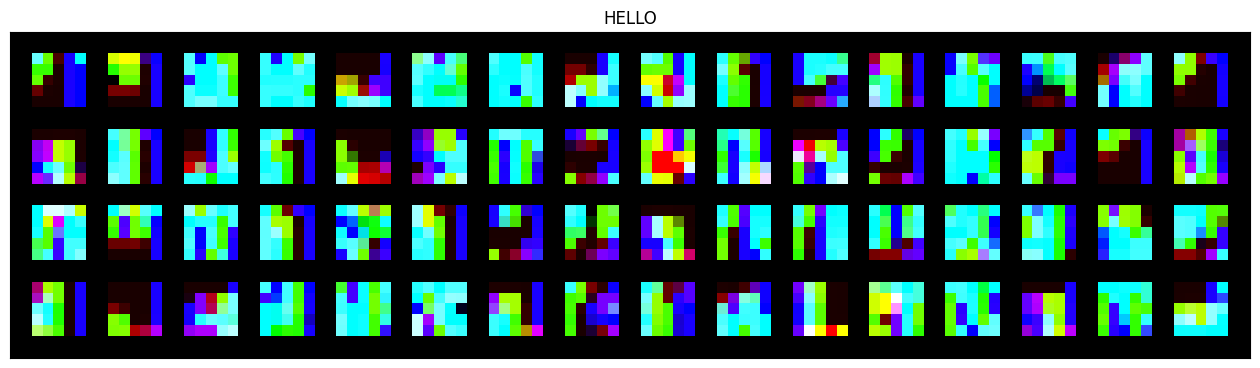

In [174]:
for images,labels in real_trainloader:
    show_batch(images)
    print("Input: ", images.shape)
    model(images.to(device),True)
    break

In [152]:
print("Real train dataset:", real_train_size)
print("Train dataset:", train_size)

Real train dataset: 885
Train dataset: 4511


In [193]:
import torch.optim as optim

#define loss function
criterion = nn.CrossEntropyLoss()

#specify
optimizer = optim.ASGD(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [161]:
epochs = 3
for epoch in range(epochs):
    print('Epoch-{0} lr: {1}'.format(epoch+1, optimizer.param_groups[0]['lr']))
    running_loss = 0
    for i,(images,classes) in enumerate(trainloader):
        if i%20==0: print(f"iteration {i}/{len(trainloader)}")
        #use GPU
        images,classes = images.to(device), classes.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs,classes)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),5)
        optimizer.step()
        
        running_loss += loss.item()
    else:
        validation_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images,classes in testloader:
                #USE GPU
                images,classes = images.to(device), classes.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, classes)
                validation_loss += loss.item()
                
                ps = torch.exp(outputs)
                top_p,top_class = ps.topk(1,dim=1)
                #reshape
                equals = top_class == classes.view(*top_class.shape)                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
            model.train()
            
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(testloader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(testloader)))
#     scheduler.step()
print("Running loss:", running_loss)

Epoch-1 lr: 0.01
iteration 0/71
iteration 20/71
iteration 40/71
iteration 60/71
Epoch: 1/3..  Training Loss: 2.079..  Valid Loss: 2.353..  Valid Accuracy: 0.440
Epoch-2 lr: 0.01
iteration 0/71
iteration 20/71
iteration 40/71
iteration 60/71
Epoch: 2/3..  Training Loss: 1.968..  Valid Loss: 2.306..  Valid Accuracy: 0.448
Epoch-3 lr: 0.01
iteration 0/71
iteration 20/71
iteration 40/71
iteration 60/71
Epoch: 3/3..  Training Loss: 1.921..  Valid Loss: 2.256..  Valid Accuracy: 0.459
Running loss: 136.37565529346466


In [194]:
epochs = 5
for epoch in range(epochs):
    print('Epoch-{0} lr: {1}'.format(epoch+1, optimizer.param_groups[0]['lr']))
    running_loss = 0
    for i,(images,classes) in enumerate(real_trainloader):
        if i%5==0: print(f"iteration {i}/{len(real_trainloader)}")
        #use GPU
        images,classes = images.to(device), classes.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs,classes)
        
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(),100)
        optimizer.step()
        
        running_loss += loss.item()
    else:
        validation_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images,classes in real_testloader:
                #USE GPU
                
                images,classes = images.to(device), classes.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, classes)
                validation_loss += loss.item()
                
                ps = torch.exp(outputs)
                top_p,top_class = ps.topk(1,dim=1)                
                #reshape
                equals = top_class == classes.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
            model.train()
            
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(real_trainloader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(real_testloader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(real_testloader)))
#     scheduler.step()
print("Running loss:", running_loss)

Epoch-1 lr: 0.001
iteration 0/14
iteration 5/14
iteration 10/14
Epoch: 1/5..  Training Loss: 0.401..  Valid Loss: 0.500..  Valid Accuracy: 0.893
Epoch-2 lr: 0.001
iteration 0/14
iteration 5/14
iteration 10/14
Epoch: 2/5..  Training Loss: 0.395..  Valid Loss: 0.537..  Valid Accuracy: 0.879
Epoch-3 lr: 0.001
iteration 0/14
iteration 5/14
iteration 10/14
Epoch: 3/5..  Training Loss: 0.391..  Valid Loss: 0.463..  Valid Accuracy: 0.905
Epoch-4 lr: 0.001
iteration 0/14
iteration 5/14
iteration 10/14
Epoch: 4/5..  Training Loss: 0.390..  Valid Loss: 0.463..  Valid Accuracy: 0.897
Epoch-5 lr: 0.001
iteration 0/14
iteration 5/14
iteration 10/14
Epoch: 5/5..  Training Loss: 0.387..  Valid Loss: 0.452..  Valid Accuracy: 0.910
Running loss: 5.42060549557209


Accuracy: 1/64
ക്തക്തഏഎഏക്തക്ലക്തക്തക്തഒക്തക്തക്തക്തഞ്ചഞ്ചക്ലഞ്ചക്തക്തക്തക്തക്തക്ലക്തക്തഉക്തആആളക്തക്തക്തക്തക്തക്തക്തക്തഞ്ചക്തക്തക്ലക്തആക്ലഞ്ചക്തക്തക്തക്തഎആക്തആഞ്ചക്തഅഎഒക്ലക്ലക്ത

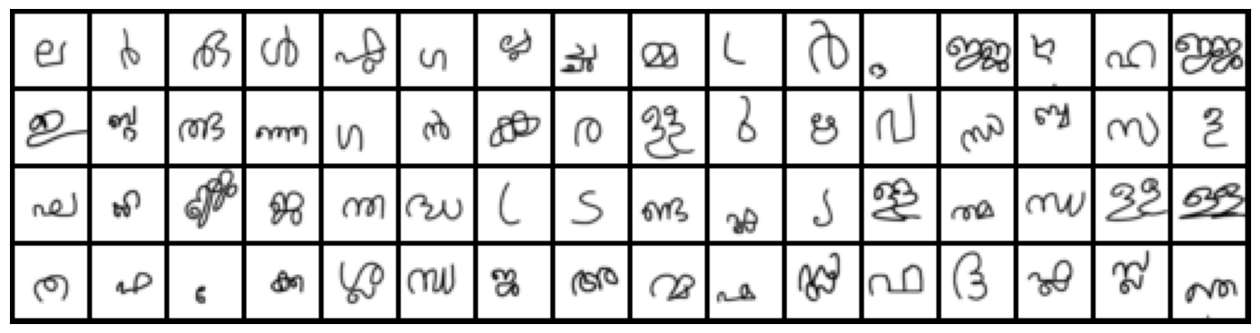

In [195]:
for images,labels in testloader:
    images, labels = images.cuda(), labels.cuda()
    predictions = predict(images, model)
    tot = 0
    for i in range(64):
        if predictions[i].item() == labels[i].item():
            tot += 1
    print(f"Accuracy: {tot}/{64}")
    # print(predictions)
    show_batch(images)
    for k in predictions:
        print(label_to_char[k.item()], end = "")
    # print(new)
    break

Accuracy: 57/64
Predicted: 
ത സ ാ ി ഉ മ ി ൗ ഋ ഷ വ വ ീ െ ഞ ഞ ഒ വ ി ക സ ാ ക ന്‍ ല്‍ ത ജ ര ഉ ീ ആ അ മ ഋ ണ്‍ െ ാ ണ്‍ ഇ ല ദ ാ ജ ച ൗ ൗ ന ൗ ദ മ ജ റ ദ ര അ ര എ ന ൗ പ െ ആ വ ക 
Actual labels: 
ത സ ാ ി ഒ മ ി ൗ ഋ ഷ വ വ ീ െ ഞ ഞ ഒ വ ി ക സ ാ ക ന്‍ ന്‍ ത ജ ര ഉ ീ ആ അ മ ഋ ന്‍ െ ാ ണ്‍ ഇ ല ദ ാ ജ ച ൗ ആ ന ൗ ദ വ ജ റ ദ ര അ ര ഏ ന ആ പ െ ആ വ ക 

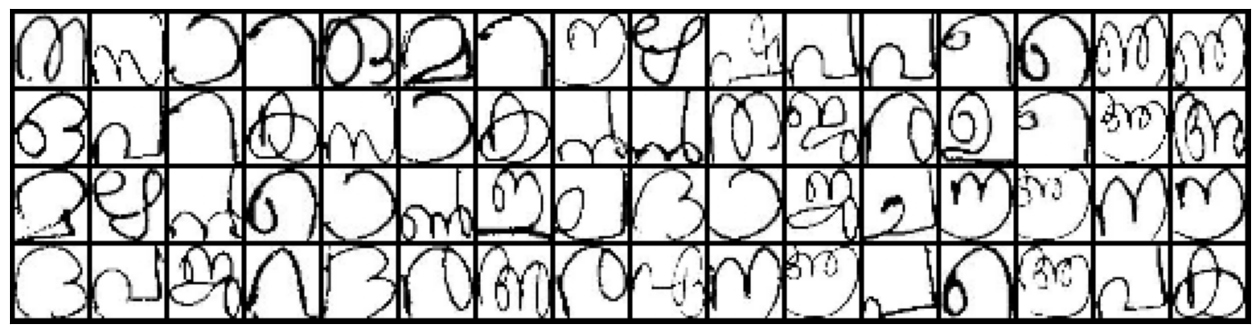

In [196]:
for images,labels in real_testloader:
    images, labels = images.cuda(), labels.cuda()
    predictions = predict(images, model)
    tot = 0
    for i in range(64):
        if predictions[i].item() == labels[i].item():
            tot += 1
    print(f"Accuracy: {tot}/{64}")
    show_batch(images)
    print("Predicted: ")
    for k in predictions:
        print(real_label_to_char.get(k.item(),'0'), end = " ")
    print("\nActual labels: ")
    for k in labels:
        print(real_label_to_char[k.item()], end=" ")
    break

## Single Real Image test

In [177]:
import cv2
img = cv2.imread('/kaggle/input/sample-character/ch1.png')
print(type(img), img.shape)

<class 'numpy.ndarray'> (9, 14, 3)


In [178]:
# torch.save(model.state_dict(), 'hcr.pt')

<Axes: >

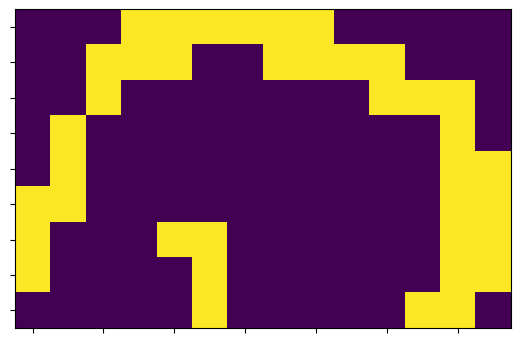

In [179]:
show(img[:,:,1])

In [180]:
img.shape

(9, 14, 3)

In [181]:
resize = transforms.Resize((height,width))
resized = transforms.ToTensor()(img)
resized = resize(resized.transpose(1,2).transpose(1,2))
print(resized.shape)

torch.Size([3, 30, 30])


Original size: (9, 14, 3)
Single batch shape: torch.Size([1, 1, 30, 30])


<Axes: >

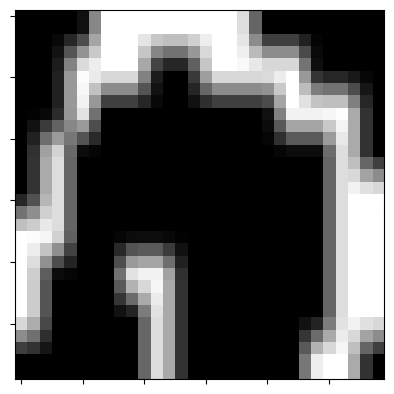

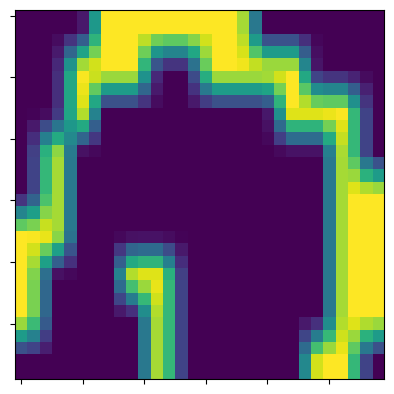

In [182]:
print("Original size:",img.shape)
show(resized)
single_batch = resized[None,:1,:,:]
print("Single batch shape:",single_batch.shape)
show(single_batch[0,:,:,:])

In [183]:
single_batch[0,0,0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0667, 0.5333, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8667, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])

<Axes: >

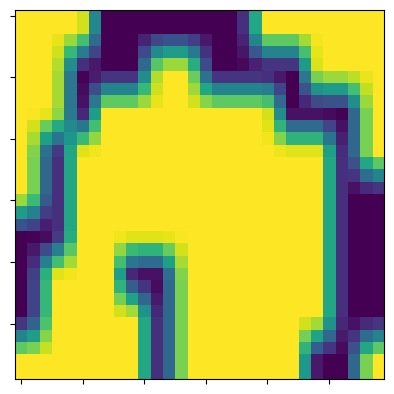

In [184]:
negated = negate(single_batch)
show(negated[0])

In [197]:
negated = negated.to(device)
prediction = predict(negated,model)

print("Predicted character: ", label_to_char[prediction[0].item()])

Predicted character:  ങ്ക
